# Main Results  


This notebook contains descriptive analyses for 2018 and 2020 data. It creates  
the main figures, descriptive findings, and supplementary tables for a forthcoming  
paper on Google Search.  

To run this file, you will need to download all of the code and data, which is 
available at:  
https://doi.org/10.7910/DVN/WANAX3  

In [1]:
# Set the working directory to the downloaded folder
!cd /home/rer/proj/gssurvey/notebooks/final

## Required Packages

In [2]:
import os
import json
import string
import itertools
import numpy as np

import pandas as pd
pd.set_option('display.width', 120)         # display width
pd.set_option('display.max_colwidth', 50)   # max single column width
pd.set_option('display.max_columns', None)  # max columns to display

import seaborn as sns
sns.set_style('ticks')

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Import custom functions
import sys
sys.path.insert(0, ".")
from functions import read_json, stringify, mm_to_inches
from functions import describe, get_nonzero_min, p_value_sig
from functions import kruskal_table, spearmanr, cumulative_sum_table
from functions import remove_xaxis_ticks, remove_yaxis_ticks, reorder_legend

## Figure Settings

In [3]:
# ==============================================================================
# Plot colors and labels
label_colors = read_json('plot_colors.json')
label_orders = read_json('plot_labels.json')

# Color maps
pid7_colors = [
    "#00488C",
    "#0074E0",
    "#428bca", 
    "#cbcaca",
    "#d27979",
    "#d31d0e",
    "#8a0f00"
]
palette_alt = dict(zip(label_orders['pid7_reduced'], pid7_colors))

# ------------------------------------------------------------------------------
# Sizing

# Sizing
# https://www.nature.com/documents/Final_guide_to_authors.pdf
# sizes: 89mm, 120mm, 183mm
FIG_WIDTH = {
    "sm": mm_to_inches(89),
    "md": mm_to_inches(120),
    "lg": mm_to_inches(180),
}
print("Figure Widths:\n", FIG_WIDTH)


# ------------------------------------------------------------------------------
# Fonts

# Output fonts in pdf as text not shape
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# "Separate panels in multi-part figures should be labelled with 8-pt bold,
# upright (not italic) a, b, c, etc. Maximum text size for all other text: 7 pt.
# Minimum text size: 5 pt"
TINY_SIZE = 6
SMALL_SIZE = 7
LARGE_SIZE = 8

# Set default font size and family
font = {'family' : "Arial", 
        'weight' : 'regular',
        'size'   : SMALL_SIZE}
plt.rc('font', **font)   
plt.rc('axes', titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TINY_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TINY_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=TINY_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

# Subplot letter font
text_letters_kws = {
    "ha": "center", 
    "va": "center", 
    "rotation": 0, 
    "weight": "bold", 
    "size": LARGE_SIZE,
}

# Title text
title_kws = {
    'ha': 'center', 
    'va': 'center', 
    'size': SMALL_SIZE
}

# Legend text
legend_base_kws = {
    'prop': {'size': TINY_SIZE},
    'frameon': False, 
}

Figure Widths:
 {'sm': 3.5039370078740157, 'md': 4.724409448818897, 'lg': 7.086614173228346}


--- 
## Load Data

### 2018

Exposure: Google SERPs  
Follows: Google History  
Engagement: Browser History  

In [4]:
# Load 2018 users
fp_users_2018 = f"data/users2018.csv"
users2018 = pd.read_csv(fp_users_2018)

# Get data source subsets
history2018 = users2018.dropna(subset=['history_window']).copy()
search2018 = users2018.dropna(subset=['search_window']).copy()
browse2018 = users2018.dropna(subset=['browse_window']).copy()
follows2018 = users2018.dropna(subset=['follow_window']).copy()

print("users:", users2018.shape)
print('search:', search2018.shape)
print('follows:', follows2018.shape)
print('browse:', browse2018.shape)
print('history:', history2018.shape)

users2018.head()

users: (358, 111)
search: (275, 111)
follows: (262, 111)
browse: (333, 111)
history: (271, 111)


,caseid,pid7_reduced,age_bin,browse_window,browse_n_total,browse_n_total_news,browse_n_total_bias,browse_n_total_fake,browse_n_total_fake_ng,browse_n_total_fake_either,browse_mean_bias,browse_mean_bias_news,browse_exposed_news,browse_exposed_fake,browse_exposed_fake_ng,browse_exposed_fake_either,browse_p_total_news,browse_p_total_fake,browse_p_total_fake_news,browse_p_total_fake_ng,browse_p_total_fake_news_ng,browse_p_total_fake_either,browse_p_total_fake_news_either,search_window,search_n_serps,search_n_results,search_n_urls,search_n_urls_bias,search_n_urls_news,search_n_urls_fake,search_n_urls_fake_ng,search_n_urls_fake_either,search_n_serps_w_news,search_n_serps_w_fake,search_n_serps_w_fake_ng,search_n_serps_w_fake_either,search_n_serps_w_fake_news,search_n_serps_w_fake_news_ng,search_n_serps_w_fake_news_either,search_mean_urls,search_mean_cmpts,search_mean_average_bias,search_mean_weighted_bias,search_mean_ranking_bias,search_mean_average_bias_news,search_mean_weighted_bias_news,search_mean_ranking_bias_news,search_p_serps_w_news,search_p_serps_w_fake,search_p_serps_w_fake_ng,search_p_serps_w_fake_either,search_p_serps_w_fake_news,search_p_serps_w_fake_news_ng,search_p_serps_w_fake_news_either,search_p_urls_news,search_p_urls_fake,search_p_urls_fake_ng,search_p_urls_fake_either,search_p_urls_news_fake,search_p_urls_news_fake_ng,search_p_urls_news_fake_either,history_window,history_n_clicks,history_n_news,history_n_bias,history_n_fake,history_n_fake_ng,history_n_fake_either,history_mean_bias,history_mean_bias_news,history_p_news,history_p_bias,history_p_fake,history_p_fake_ng,history_p_fake_either,history_p_fake_news,history_p_fake_news_ng,history_p_fake_news_either,follow_window,follow_n_clicks,follow_n_news,follow_n_bias,follow_n_fake,follow_n_fake_ng,follow_n_fake_either,follow_mean_bias,follow_mean_bias_news,follow_p_news,follow_p_bias,follow_p_fake,follow_p_fake_ng,follow_p_fake_either,follow_p_fake_news,follow_p_fake_news_ng,follow_p_fake_news_either,race,newsint,college,female,high_news,age_group,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,0,Strong Republican,45 - 64,56.559896,17702.072619,1067.085714,6701.429762,1.0,16.0,16.0,0.026354,0.009851,1.0,1.0,1.0,1.0,0.060280,0.000056,0.000937,0.000904,0.014994,0.000904,0.014994,71.912535,425.0,6085.0,4590.0,2653.0,786.0,2.0,7.0,9.0,202.0,1.0,7.0,8.0,1.0,7.0,8.0,10.800000,4.574118,0.022952,0.025483,0.002530,-0.076663,-0.059884,0.016780,0.475294,0.002353,0.016471,0.018824,0.004950,0.034653,0.039604,0.171242,0.000436,0.001525,0.001961,0.002545,0.008906,0.011450,211.640972,1891.0,171.0,702.0,2.0,2.0,4.0,0.110985,0.006522,0.090428,0.371232,0.001058,0.001058,0.002115,0.011696,0.011696,0.023392,208.889977,592.0,40.0,194.0,0.0,1.0,1.0,0.081325,0.005572,0.067568,0.327703,0.0,0.001689,0.001689,0.0,0.025000,0.025000,White,Most of the time,0,1,1,45-64,0.142325,-0.038989,0.000549,-0.029536,0.015156,0.028107,-0.015177,-0.013273,0.017269,0.030273
1,1,Not very strong Republican,25 - 44,89.445694,19758.000000,806.000000,16569.000000,0.0,3.0,3.0,-0.021368,-0.044449,1.0,0.0,1.0,1.0,0.040794,0.000000,0.000000,0.000152,0.003722,0.000152,0.003722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,White,Most of the time,1,1,1,25-44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Lean Democrat,65+,160.046123,46550.031349,2004.611111,18108.027778,0.0,3.0,3.0,0.038651,0.044076,1.0,0.0,1.0,1.0,0.043064,0.000000,0.000000,0.000064,0.001497,0.000064,0.001497,48.014306,134.0,2126.0,1680.0,949.0,303.0,2.0,4.0,6.0,71.0,2.0,4.0,6.0,2.0,4.0,6.0,12.537313,5.276119,-0.020694,-0.007858,0.012836,-0.075293,-0.064424,0.010869,0.529851,0.014925,0.029851,0.044776,0.028169,0.056338,0.084507,0.180357,0.001190,0.002381,0.003571,0.006601,0.013201,0.019802,59.333715,9124.0,453.0,4238.0,0.0,1.0,1.0,0.138

### 2020

Exposure: Google SERPs    
Follows: Tab Activity  
Engagement: Browser History  

In [5]:
# Load 2020 users
fp_users_2020 = f"data/users2020.csv"
users2020 = pd.read_csv(fp_users_2020)

# Get data source subsets
activity2020 = users2020.dropna(subset=['activity_window']).copy()
follows2020 = users2020.dropna(subset=['activity_gs_follow_window']).copy()
search2020 = users2020.dropna(subset=['activity_gs_search_window']).copy()
browse2020 = users2020.dropna(subset=['browser_history_window']).copy()

print('users:', users2020.shape)
print('search:', search2020.shape)
print('follows:', follows2020.shape)
print('activity:', activity2020.shape)
print('browse:', browse2020.shape)

users2020.head()

users: (795, 116)
search: (459, 116)
follows: (418, 116)
activity: (597, 116)
browse: (688, 116)


,user_id,pid7_reduced,age_bin,interest,activity_window,activity_n_total,activity_n_urls,activity_n_bias,activity_n_news,activity_n_fake,activity_n_fake_ng,activity_n_fake_either,activity_mean_bias,activity_mean_bias_news,activity_p_news,activity_p_fake,activity_p_fake_ng,activity_p_fake_either,activity_p_fake_news,activity_p_fake_news_ng,activity_p_fake_news_either,browser_history_window,browser_history_n_total,browser_history_n_urls,browser_history_n_bias,browser_history_n_news,browser_history_n_fake,browser_history_n_fake_ng,browser_history_n_fake_either,browser_history_mean_bias,browser_history_mean_bias_news,browser_history_p_news,browser_history_p_fake,browser_history_p_fake_ng,browser_history_p_fake_either,browser_history_p_fake_news,browser_history_p_fake_news_ng,browser_history_p_fake_news_either,activity_gs_search_window,activity_gs_search_n_serps,activity_gs_search_n_cmpts,activity_gs_search_n_results,activity_gs_search_n_urls,activity_gs_search_n_urls_bias,activity_gs_search_n_urls_news,activity_gs_search_n_urls_fake,activity_gs_search_n_urls_fake_ng,activity_gs_search_n_urls_fake_either,activity_gs_search_n_serps_w_news,activity_gs_search_n_serps_w_fake,activity_gs_search_n_serps_w_fake_ng,activity_gs_search_n_serps_w_fake_either,activity_gs_search_n_serps_w_fake_news,activity_gs_search_n_serps_w_fake_news_ng,activity_gs_search_n_serps_w_fake_news_either,activity_gs_search_mean_urls,activity_gs_search_mean_cmpts,activity_gs_search_mean_average_bias,activity_gs_search_mean_weighted_bias,activity_gs_search_mean_ranking_bias,activity_gs_search_mean_average_bias_news,activity_gs_search_mean_weighted_bias_news,activity_gs_search_mean_ranking_bias_news,activity_gs_search_p_serps_w_news,activity_gs_search_p_serps_w_fake,activity_gs_search_p_serps_w_fake_ng,activity_gs_search_p_serps_w_fake_either,activity_gs_search_p_serps_w_fake_news,activity_gs_search_p_serps_w_fake_news_ng,activity_gs_search_p_serps_w_fake_news_either,activity_gs_search_p_urls_news,activity_gs_search_p_urls_fake,activity_gs_search_p_urls_fake_ng,activity_gs_search_p_urls_fake_either,activity_gs_search_p_urls_fake_news,activity_gs_search_p_urls_fake_news_ng,activity_gs_search_p_urls_fake_news_either,activity_gs_follow_window,activity_gs_follow_n_total,activity_gs_follow_n_urls,activity_gs_follow_n_bias,activity_gs_follow_n_news,activity_gs_follow_n_fake,activity_gs_follow_n_fake_ng,activity_gs_follow_n_fake_either,activity_gs_follow_n_unique_urls,activity_gs_follow_n_unique_domains,activity_gs_follow_n_unique_urls_bias,activity_gs_follow_n_unique_urls_news,activity_gs_follow_n_unique_urls_fake,activity_gs_follow_mean_bias,activity_gs_follow_mean_bias_news,activity_gs_follow_p_news,activity_gs_follow_p_fake,activity_gs_follow_p_fake_ng,activity_gs_follow_p_fake_either,activity_gs_follow_p_fake_news,activity_gs_follow_p_fake_news_ng,activity_gs_follow_p_fake_news_either,party7,party_cat,age_group,high_interest,college,female,race_r,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,0,Not very strong Democrat,65+,Extremely interested,93.402708,46377.0,42360.0,10603.0,5042.0,0.0,40.0,40.0,0.140141,0.079208,0.119027,0.000000,0.000944,0.000944,0.000000,0.007933,0.007933,182.351169,88605.0,88605.0,20135.0,10815.0,0.0,64.0,64.0,0.127419,0.101427,0.122059,0.000000,0.000722,0.000722,0.000000,0.005918,0.005918,78.824387,365.0,4045.0,5825.0,5320.0,3187.0,1124.0,2.0,0.0,2.0,268.0,2.0,0.0,2.0,2.0,0.0,2.0,14.575342,11.082192,-0.010462,-0.000552,0.009910,-0.003231,0.004302,0.007533,0.734247,0.005479,0.000000,0.005479,0.007463,0.000000,0.007463,0.211278,0.000376,0.000000,0.000376,0.001779,0.000000,0.001779,76.934734,136.0,136.0,77.0,26.0,0.0,0.0,0.0,98.0,69.0,52.0,15.0,0.0,0.185295,0.266331,0.191176,0.0,0.0,0.0,0.0,0.0,0.0,6,Not very strong D,65+,1,0,0,1,-0.313671,-0.022183,-0.038310,-0.077793,0.011090,-0.015982,-0.015200,-0.015841,0.023716,0.009580
1,1,Independent/Not sure,25 - 44,Somewhat interested,116.136609,103262.0,97233.0,35249.0,2502.0,12.0,123.0,125.0,-0.042466,0.031214,0.025732,

In [6]:
# Dataframe dictionary reference
dataframes = {
    'search2018': search2018,
    'follows2018': follows2018,
    'browse2018': browse2018,
    'history2018': history2018,
    'search2020': search2020,
    'follows2020': follows2020,
    'activity2020': activity2020,
    'browse2020': browse2020,
}

---
## Table: Totals Counts

In [7]:
# Output filepath
FP_TABLE = 'tables/data_counts.tex'

# Table values
tab = pd.DataFrame([
{
    'year': '2018', 
    'type': "Google Search Exposure",
    'name': "Google SERPs",
    'days observed': search2018[f'search_window'].max(),
    'participants': search2018['caseid'].nunique(),
    'searches': search2018['search_n_serps'].sum(),
    'urls': search2018['search_n_urls'].sum(),
    'news': search2018['search_n_urls_news'].sum(),
    'unreliable': search2018['search_n_urls_fake_either'].sum(),
},
{
    'year': '2018', 
    'type': "Google Search Follows",
    'name': 'Google History',
    'days observed': follows2018[f'follow_window'].max(),
    'participants': follows2018['caseid'].nunique(),
    'urls': follows2018['follow_n_clicks'].sum(),
    'news': follows2018['follow_n_news'].sum(),
    'unreliable': follows2018['follow_n_fake_either'].sum(),
},
{
    'year': '2018', 
    'type': "Overall Engagement",
    'name': 'Browser History',
    'days observed': browse2018[f'browse_window'].max(),
    'participants': browse2018['caseid'].nunique(),
    'urls': browse2018['browse_n_total'].sum(),
    'news': browse2018['browse_n_total_news'].sum(),
    'unreliable': browse2018['browse_n_total_fake_either'].sum(),
},    
{
    'year': '2018', 
    'type': "Overall Engagement",
    'name': 'Google History',
    'days observed': history2018[f'history_window'].max(),
    'participants': history2018['caseid'].nunique(),
    'urls': history2018['history_n_clicks'].sum(),
    'news': history2018['history_n_news'].sum(),
    'unreliable': history2018['history_n_fake_either'].sum(),
},
{
    'year': '2020', 
    'type': "Google Search Exposure",
    'name': "Google SERPs",
    'days observed': search2020['activity_gs_search_window'].max(),
    'participants': search2020['user_id'].nunique(),
    'searches': search2020['activity_gs_search_n_serps'].sum(),
    'urls': search2020['activity_gs_search_n_urls'].sum(),
    'news': search2020['activity_gs_search_n_urls_news'].sum(),
    'unreliable': search2020['activity_gs_search_n_urls_fake_either'].sum(),
},
{
    'year': '2020', 
    'type': "Google Search Follows",
    'name': "Tab Activity",
    'days observed': follows2020['activity_gs_follow_window'].max(),
    'participants': follows2020['user_id'].nunique(),
    'urls': follows2020['activity_gs_follow_n_urls'].sum(),
    'news': follows2020['activity_gs_follow_n_news'].sum(),
    'unreliable': follows2020['activity_gs_follow_n_fake_either'].sum(),
},
{
    'year': '2020', 
    'type': "Overall Engagement",
    'name': 'Browser History',
    'days observed': browse2020['browser_history_window'].max(),
    'participants': browse2020['user_id'].nunique(),
    'urls': browse2020['browser_history_n_urls'].sum(),
    'news': browse2020['browser_history_n_news'].sum(),
    'unreliable': browse2020['browser_history_n_fake_either'].sum(),
},
{
    'year': '2020', 
    'type': "Overall Engagement",
    'name': 'Tab Activity',
    'days observed': activity2020['activity_window'].max(),
    'participants': activity2020['user_id'].nunique(),
    'urls': activity2020['activity_n_urls'].sum(),
    'news': activity2020['activity_n_news'].sum(),
    'unreliable': activity2020['activity_n_fake_either'].sum(),
},
])

# Reformat table
cols_index = ['year', 'type', 'name']
cols_value = [
    'days observed',
    'participants',
    'searches',
    'urls',
    'news',
    'unreliable',
]
outtab = tab[cols_index + cols_value].copy()
outtab[cols_value] = outtab[cols_value].apply(stringify, fmt=",.0f")
outtab.set_index(cols_index, inplace=True)
display(outtab)

# Save LaTeX table
outtab.style.to_latex(column_format='lllrrllll', buf=FP_TABLE)
print(f"saved: {FP_TABLE}")

# NOTE: in the published table, days observed was calculated with the minimum 
# start and end dates across participants using columns that were removed while 
# preparing the public data. As a result, this table results has slightly 
# different numbers because it is the maximum within-participant window, rather
# than the maximum across-participants window.

days observed participants searches        urls       news unreliable
year type                   name                                                                                 
2018 Google Search Exposure Google SERPs               74          275  102,114   1,245,155    215,699      3,932
     Google Search Follows  Google History            254          262        -     279,680     22,946        661
     Overall Engagement     Browser History           253          333        -  14,677,297    994,032     29,081
                            Google History            254          271        -   4,807,758    405,596     16,754
2020 Google Search Exposure Google SERPs              203          459  226,035   3,654,829    586,803      5,184
     Google Search Follows  Tab Activity              203          418        -      69,023      8,125        112
     Overall Engagement     Browser History           291          688        -  31,202,830  1,862,011     13,209
                            Tab Activity              205          597        -  20,260,394  1,897,933     11,880

saved: tables/data_counts.tex


---
## Table: Count Averages

In [8]:
# Output filepath
FP_TABLE = 'tables/overall_averages.tex'

# Table values
tab = pd.DataFrame([
{
    'year': '2018', 
    'type': "Google Search Exposure",
    'name': "Google SERPs",
    'searches': search2018['search_n_serps'].mean(),
    'searches_std': search2018['search_n_serps'].std(),
    'urls': search2018['search_n_urls'].mean(),
    'urls_std': search2018['search_n_urls'].std(),
    'news': search2018['search_n_urls_news'].mean(),
    'news_std': search2018['search_n_urls_news'].std(),
    'unreliable': search2018['search_n_urls_fake_either'].mean(),
    'unreliable_std': search2018['search_n_urls_fake_either'].std(),
    'prop. news': search2018['search_p_urls_news'].mean(),
    'prop. unreliable': search2018['search_p_urls_fake'].mean(),
    'prop. unreliable (news)': search2018['search_p_urls_news_fake_either'].mean(),
    'prop. news (searches)': search2018['search_p_serps_w_news'].mean(),
    'prop. unreliable (searches)': search2018['search_p_serps_w_fake_either'].mean(),
    'prop. unreliable (news searches)': search2018['search_p_serps_w_fake_news_either'].mean(),
},
{
    'year': '2018', 
    'type': "Google Search Follows",
    'name': "Google History",
    'urls': follows2018['follow_n_clicks'].mean(),
    'urls_std': follows2018['follow_n_clicks'].std(),
    'news': follows2018['follow_n_news'].mean(),
    'news_std': follows2018['follow_n_news'].std(),
    'unreliable': follows2018['follow_n_fake_either'].mean(),
    'unreliable_std': follows2018['follow_n_fake_either'].std(),
    'prop. news': follows2018['follow_p_news'].mean(),
    'prop. unreliable': follows2018['follow_p_fake_either'].mean(),
    'prop. unreliable (news)': follows2018['follow_p_fake_news_either'].mean(),
},
{
    'year': '2018', 
    'type': "Overall Engagement",
    'name': 'Browser History',
    'urls': browse2018['browse_n_total'].mean(),
    'urls_std': browse2018['browse_n_total'].std(),
    'news': browse2018['browse_n_total_news'].mean(),
    'news_std': browse2018['browse_n_total_news'].std(),
    'unreliable': browse2018['browse_n_total_fake_either'].mean(),
    'unreliable_std': browse2018['browse_n_total_fake_either'].std(),   
    'prop. news': browse2018['browse_p_total_news'].mean(),
    'prop. unreliable': browse2018['browse_p_total_fake_either'].mean(),
    'prop. unreliable (news)': browse2018['browse_p_total_fake_news_either'].mean(),
},
{
    'year': '2018', 
    'type': "Overall Engagement",
    'name': 'Google History',
    'urls': history2018['history_n_clicks'].mean(),
    'urls_std': history2018['history_n_clicks'].std(),
    'news': history2018['history_n_news'].mean(),
    'news_std': history2018['history_n_news'].std(),
    'unreliable': history2018['history_n_fake_either'].mean(),
    'unreliable_std': history2018['history_n_fake_either'].std(),
    'prop. news': history2018['history_p_news'].mean(),
    'prop. unreliable': history2018['history_p_fake_either'].mean(),
    'prop. unreliable (news)': history2018['history_p_fake_news_either'].mean(),
},
{
    'year': '2020', 
    'type': "Google Search Exposure",
    'name': "Google SERPs",
    'searches': search2020['activity_gs_search_n_serps'].mean(),
    'searches_std': search2020['activity_gs_search_n_serps'].std(),
    'urls': search2020['activity_gs_search_n_urls'].mean(),
    'urls_std': search2020['activity_gs_search_n_urls'].std(),
    'news': search2020['activity_gs_search_n_urls_news'].mean(),
    'news_std': search2020['activity_gs_search_n_urls_news'].std(),
    'unreliable': search2020['activity_gs_search_n_urls_fake_either'].mean(),
    'unreliable_std': search2020['activity_gs_search_n_urls_fake_either'].std(),
    'prop. news': search2020['activity_gs_search_p_urls_news'].mean(),
    'prop. unreliable': search2020['activity_gs_search_p_urls_fake_either'].mean(),
    'prop. unreliable (news)': search2020['activity_gs_search_p_urls_fake_news_either'].mean(),
    'prop. news (searches)': search2020['activity_gs_search_p_serps_w_news'].mean(),
    'prop. unreliable (searches)': search2020['activity_gs_search_p_serps_w_fake_either'].mean(),
    'prop. unreliable (news searches)': search2020['activity_gs_search_p_serps_w_fake_news_either'].mean(),
},
{
    'year': '2020', 
    'type': "Google Search Follows",
    'name': "Tab Activity",
    'urls': follows2020['activity_gs_follow_n_urls'].mean(),
    'urls_std': follows2020['activity_gs_follow_n_urls'].std(),
    'news': follows2020['activity_gs_follow_n_news'].mean(),
    'news_std': follows2020['activity_gs_follow_n_news'].std(),
    'unreliable': follows2020['activity_gs_follow_n_fake_either'].mean(),
    'unreliable_std': follows2020['activity_gs_follow_n_fake_either'].std(),
    'prop. news': follows2020['activity_gs_follow_p_news'].mean(),
    'prop. unreliable': follows2020['activity_gs_follow_p_fake_either'].mean(),
    'prop. unreliable (news)': follows2020['activity_gs_follow_p_fake_news_either'].mean(),

},
{
    'year': '2020', 
    'type': "Overall Engagement",
    'name': 'Browser History',
    'urls': browse2020['browser_history_n_urls'].mean(),
    'urls_std': browse2020['browser_history_n_urls'].std(),
    'news': browse2020['browser_history_n_news'].mean(),
    'news_std': browse2020['browser_history_n_news'].std(),
    'unreliable': browse2020['browser_history_n_fake_either'].mean(),
    'unreliable_std': browse2020['browser_history_n_fake_either'].std(),
    'prop. news': browse2020['browser_history_p_news'].mean(),
    'prop. unreliable': browse2020['browser_history_p_fake_either'].mean(),
    'prop. unreliable (news)': browse2020['browser_history_p_fake_news_either'].mean(),
},
{
    'year': '2020', 
    'type': "Overall Engagement",
    'name': 'Tab Activity',
    'urls': activity2020['activity_n_urls'].mean(),
    'urls_std': activity2020['activity_n_urls'].std(),
    'news': activity2020['activity_n_news'].mean(),
    'news_std': activity2020['activity_n_news'].std(),
    'unreliable': activity2020['activity_n_fake_either'].mean(),
    'unreliable_std': activity2020['activity_n_fake_either'].std(),
    'prop. news': activity2020['activity_p_news'].mean(),
    'prop. unreliable': activity2020['activity_p_fake_either'].mean(),
    'prop. unreliable (news)': activity2020['activity_p_fake_news_either'].mean(),
},
])

# Average Counts
cols_index = ['year', 'type', 'name']
cols_value = [
    'searches', 'searches_std',
    'urls', 'urls_std',
    'news', 'news_std',
    'unreliable', 'unreliable_std'
]
outtab = tab[cols_index + cols_value].copy()
outtab[cols_value] = outtab[cols_value].apply(stringify, fmt=",.1f")
outtab.set_index(cols_index, inplace=True)
display(outtab)

# Save LaTeX table
outtab.style.to_latex(column_format='lllrrllll', buf=FP_TABLE)
print(f"saved: {FP_TABLE}")


searches searches_std      urls  urls_std     news  news_std unreliable  \
year type                   name                                                                                      
2018 Google Search Exposure Google SERPs       371.3        499.7   4,527.8   6,660.8    784.4   1,489.5       14.3   
     Google Search Follows  Google History         -            -   1,067.5   1,398.3     87.6     136.0        2.5   
     Overall Engagement     Browser History        -            -  44,076.0  49,388.1  2,985.1   9,625.4       87.3   
                            Google History         -            -  17,740.8  27,620.9  1,496.7   2,624.3       61.8   
2020 Google Search Exposure Google SERPs       492.5        811.4   7,962.6  13,594.3  1,278.4   3,037.2       11.3   
     Google Search Follows  Tab Activity           -            -     165.1     252.2     19.4      53.3        0.3   
     Overall Engagement     Browser History        -            -  45,353.0  54,583.6  2,706.4  14,323.9       19.2   
                            Tab Activity           -            -  33,937.0  49,347.3  3,179.1  16,022.8       19.9   

                                            unreliable_std  
year type                   name                            
2018 Google Search Exposure Google SERPs              35.3  
     Google Search Follows  Google History             6.9  
     Overall Engagement     Browser History          467.0  
                            Google History           212.2  
2020 Google Search Exposure Google SERPs              30.1  
     Google Search Follows  Tab Activity               1.4  
     Overall Engagement     Browser History           80.0  
                            Tab Activity              78.3

saved: tables/overall_averages.tex


---
## Table: News Percentages

In [9]:
FP_TABLE = 'tables/news_percentages.tex'

# Select index and value columns
cols_index = ['year', 'type', 'name']
cols_value = [
    'prop. news', 
    'prop. unreliable',
    'prop. unreliable (news)',
    'prop. news (searches)', 
    'prop. unreliable (searches)',
    'prop. unreliable (news searches)'
]

# Format table for readability
outtab = tab[cols_index + cols_value].copy()
outtab[cols_value] = outtab[cols_value].apply(stringify, fmt=".2%")
outtab.set_index(cols_index, inplace=True)
display(outtab)

# Save LaTeX table
outtab[cols_value] = outtab[cols_value].replace("\%", "\\%", regex=True)
outtab.style.to_latex(column_format='lllrrllll', buf=FP_TABLE)
print(f"saved: {FP_TABLE}")

prop. news prop. unreliable prop. unreliable (news) prop. news (searches)  \
year type                   name                                                                                        
2018 Google Search Exposure Google SERPs        14.31%            0.12%                   2.05%                45.61%   
     Google Search Follows  Google History       8.10%            0.23%                   2.36%                     -   
     Overall Engagement     Browser History      7.11%            0.23%                   3.03%                     -   
                            Google History      10.91%            0.54%                   3.64%                     -   
2020 Google Search Exposure Google SERPs        14.71%            0.10%                   0.72%                52.25%   
     Google Search Follows  Tab Activity         8.89%            0.10%                   0.93%                     -   
     Overall Engagement     Browser History      3.24%            0.04%                   1.86%                     -   
                            Tab Activity         3.97%            0.06%                   2.15%                     -   

                                            prop. unreliable (searches) prop. unreliable (news searches)  
year type                   name                                                                          
2018 Google Search Exposure Google SERPs                          2.46%                            4.79%  
     Google Search Follows  Google History                            -                                -  
     Overall Engagement     Browser History                           -                                -  
                            Google History                            -                                -  
2020 Google Search Exposure Google SERPs                          1.18%                            2.18%  
     Google Search Follows  Tab Activity                              -                                -  
     Overall Engagement     Browser History                           -                                -  
                            Tab Activity                              -                                -

saved: tables/news_percentages.tex


---
## Table: Kruskal-Wallis Tests

In [10]:
FP_TABLE = 'tables/kruskal_tests.tex'
groups = ['age_bin', 'pid7_reduced']

# 2018 ------------------------------------

# Search
prefix = 'search'
metrics=["mean_weighted_bias_news", 'p_serps_w_fake_news_either']
metrics = [f"{prefix}_{m}" for m in metrics]
tab2018 = kruskal_table(search2018, groups, metrics)
tab2018['type'] = 'Google Search Exposure'
tab2018['name'] = 'Google SERPs'

# Follows
prefix = 'follow'
metrics = ['mean_bias_news', 'p_fake_news_either']
metrics = [f"{prefix}_{m}" for m in metrics]
_tab = kruskal_table(follows2018, groups, metrics)
_tab['type'] = 'Google Search Follows'
_tab['name'] = 'Google History'
tab2018 = pd.concat([tab2018, _tab])

# Browser History
prefix = 'browse'
metrics = ['mean_bias_news', 'p_total_fake_news_either']
metrics = [f"{prefix}_{m}" for m in metrics]
_tab = kruskal_table(browse2018, groups, metrics)
_tab['type'] = 'Overall Engagement'
_tab['name'] = 'Browser History'
tab2018 = pd.concat([tab2018, _tab])

# Google History
prefix = 'history'
metrics = ['mean_bias_news', 'p_fake_news_either']
metrics = [f"{prefix}_{m}" for m in metrics]
_tab = kruskal_table(history2018, groups, metrics)
_tab['type'] = 'Overall Engagement'
_tab['name'] = 'Google History'
tab2018 = pd.concat([tab2018, _tab])

tab2018['year'] = 2018

# 2020 ------------------------------------

# Search
prefix = 'activity_gs_search'
metrics=["mean_weighted_bias_news", 'p_serps_w_fake_news_either']
metrics = [f"{prefix}_{m}" for m in metrics]
tab2020 = kruskal_table(search2020, groups, metrics)
tab2020['type'] = 'Google Search Exposure'
tab2020['name'] = 'Google SERPs'

# Follows
prefix = 'activity_gs_follow'
metrics = ['mean_bias_news', 'p_fake_news_either']
metrics = [f"{prefix}_{m}" for m in metrics]
_tab = kruskal_table(follows2020, groups, metrics)
_tab['type'] = 'Google Search Follows'
_tab['name'] = 'Tab Activity'
tab2020 = pd.concat([tab2020, _tab])

# Browse
prefix = 'browser_history'
metrics = ['mean_bias_news', 'p_fake_news_either']
metrics = [f"{prefix}_{m}" for m in metrics]
_tab = kruskal_table(browse2020, groups, metrics)
_tab['type'] = 'Overall Engagement'
_tab['name'] = 'Browser History'
tab2020 = pd.concat([tab2020, _tab])

# Activity
prefix = 'activity'
metrics = ['mean_bias_news', 'p_fake_news_either']
metrics = [f"{prefix}_{m}" for m in metrics]
_tab = kruskal_table(activity2020, groups, metrics)
_tab['type'] = 'Overall Engagement'
_tab['name'] = 'Tab Activity'
tab2020 = pd.concat([tab2020, _tab])

tab2020['year'] = 2020

# Combine ------------------------------------

tab = pd.concat([tab2018, tab2020])
group_map = {'age_bin':'Age Bin', 'pid7_reduced':'7-Point Party ID'}
tab['group'] = tab['group'].map(group_map)

tab['metric'] = tab['metric'].apply(lambda s: 'Partisanship' if '_bias' in s else s)
tab['metric'] = tab['metric'].apply(lambda s: 'Unreliable' if '_fake' in s else s)

tab = tab.set_index(['year', 'type', 'name', 'group', 'metric'])
# display(tab)

# Format multi-index column
tab = tab.unstack('metric')
tab.columns = tab.columns.swaplevel(0, 1)
tab.sort_index(axis=1, level=0, inplace=True)
cols_0 = pd.Categorical(tab.columns.get_level_values(0), ordered=True,
                        categories=['Partisanship', 'Unreliable'])
cols_1 = pd.Categorical(tab.columns.get_level_values(1), ordered=True,
                        categories=['n', 'H', 'P'])
tab.columns = pd.MultiIndex.from_arrays([cols_0, cols_1]) 
tab = tab.sort_index(axis=1, level=[0, 1])

# Save to latex file
tab.style.to_latex(column_format='rrrrrllrll', buf=FP_TABLE)
print(f'saved: {FP_TABLE}')
display(tab)


saved: tables/kruskal_tests.tex


Partisanship                  Unreliable                 
                                                                        n      H         P          n      H         P
year type                   name            group                                                                     
2018 Google Search Exposure Google SERPs    7-Point Party ID          270  23.25  0.001***        275  11.15     0.084
                                            Age Bin                   270  12.64   0.005**        275   0.71     0.871
     Google Search Follows  Google History  7-Point Party ID          247  36.27  0.000***        262   5.21     0.517
                                            Age Bin                   247   6.80     0.079        262   1.85     0.605
     Overall Engagement     Browser History 7-Point Party ID          319  72.22  0.000***        333  34.06  0.000***
                                            Age Bin                   319  23.23  0.000***        333  19.01  0.000***
                            Google History  7-Point Party ID          270  66.86  0.000***        271  16.26    0.012*
                                            Age Bin                   270  11.78   0.008**        271   2.45     0.484
2020 Google Search Exposure Google SERPs    7-Point Party ID          453  18.97   0.004**        459   4.05     0.670
                                            Age Bin                   453  29.48  0.000***        459   1.22     0.748
     Google Search Follows  Tab Activity    7-Point Party ID          329  28.01  0.000***        418   2.85     0.827
                                            Age Bin                   329  24.25  0.000***        418   0.57     0.903
     Overall Engagement     Browser History 7-Point Party ID          655  86.53  0.000***        688  18.17   0.006**
                                            Age Bin                   655  29.28  0.000***        688  32.01  0.000***
                            Tab Activity    7-Point Party ID          546  57.72  0.000***        597  19.18   0.004**
                                            Age Bin                   546  27.54  0.000***        597  34.76  0.000***

---

## Table: Column Reference

In [11]:
# Partisan score columns
colinfo_tuples = [
(2018, 'search_mean_weighted_bias', 'Google Search Exposure', 'Google SERPs', 'main', 'search2018'),
(2018, 'search_mean_weighted_bias_news', 'Google Search Exposure', 'Google SERPs', 'main', 'search2018'),
(2018, 'follow_mean_bias', 'Google Search Follows', 'Google History', 'main', 'follows2018'),
(2018, 'follow_mean_bias_news', 'Google Search Follows', 'Google History', 'main', 'follows2018'),
(2018, 'browse_mean_bias', 'Overall Engagement', 'Browser History', 'main', 'browse2018'),
(2018, 'browse_mean_bias_news', 'Overall Engagement', 'Browser History', 'main', 'browse2018'),
(2018, 'history_mean_bias', 'Overall Engagement', 'Google History', 'si', 'history2018'),
(2018, 'history_mean_bias_news', 'Overall Engagement', 'Google History', 'si', 'history2018'),
(2020, 'activity_gs_search_mean_weighted_bias', 'Google Search Exposure', 'Google SERPs', 'main', 'search2020'),
(2020, 'activity_gs_search_mean_weighted_bias_news', 'Google Search Exposure', 'Google SERPs', 'main', 'search2020'),
(2020, 'activity_gs_follow_mean_bias', 'Google Search Follows', 'Tab Activity', 'main', 'follows2020'),
(2020, 'activity_gs_follow_mean_bias_news', 'Google Search Follows', 'Tab Activity', 'main', 'follows2020'),
(2020, 'browser_history_mean_bias', 'Overall Engagement', 'Browser History', 'main', 'browse2020'),
(2020, 'browser_history_mean_bias_news', 'Overall Engagement', 'Browser History', 'main', 'browse2020'),
(2020, 'activity_mean_bias', 'Overall Engagement', 'Tab Activity', 'si', 'activity2020'),
(2020, 'activity_mean_bias_news', 'Overall Engagement', 'Tab Activity', 'si', 'activity2020')
]

cols = ('year', 'col', 'datatype', 'dataset', 'result', 'dataframe')
colinfo_partisanship = pd.DataFrame(colinfo_tuples, columns=cols)
colinfo_partisanship['coltype'] = 'partisanship'

colinfo_tuples = [
(2018, 'search_p_urls_news_fake_either', 'Google Search Exposure', 'Google SERPs', 'main', 'search2018'),
(2018, 'history_p_fake_news_either', "Overall Engagement", "Google History", 'si', 'history2018'),
(2018, 'browse_p_total_fake_news_either', "Overall Engagement", "Browser History", 'main', 'browse2018'),
(2018, 'follow_p_fake_news_either', "Google Search Follows", "Google History", 'main', 'follows2018'),    
(2020, 'activity_gs_search_p_urls_fake_news_either', "Google Search Exposure", 'Google SERPs', 'main', 'search2020'),
(2020, 'activity_p_fake_news_either', "Overall Engagement", "Tab Activity", 'si', 'activity2020'),
(2020, 'browser_history_p_fake_news_either', "Overall Engagement", "Browser History", 'main', 'browse2020'),
(2020, 'activity_gs_follow_p_fake_news_either',  "Google Search Follows", "Tab Activity", 'main', 'follows2020')
]
    
cols = ('year', 'col', 'datatype', 'dataset', 'result', 'dataframe')
colinfo_unreliable = pd.DataFrame(colinfo_tuples, columns=cols)
colinfo_unreliable['coltype'] = 'unreliable'

colinfo = pd.concat([colinfo_partisanship, colinfo_unreliable])
colinfo

,year,col,datatype,dataset,result,dataframe,coltype
0,2018,search_mean_weighted_bias,Google Search Exposure,Google SERPs,main,search2018,partisanship
1,2018,search_mean_weighted_bias_news,Google Search Exposure,Google SERPs,main,search2018,partisanship
2,2018,follow_mean_bias,Google Search Follows,Google History,main,follows2018,partisanship
3,2018,follow_mean_bias_news,Google Search Follows,Google History,main,follows2018,partisanship
4,2018,browse_mean_bias,Overall Engagement,Browser History,main,browse2018,partisanship
5,2018,browse_mean_bias_news,Overall Engagement,Browser History,main,browse2018,partisanship
6,2018,history_mean_bias,Overall Engagement,Google History,si,history2018,partisanship
7,2018,history_mean_bias_news,Overall Engagement,Google History,si,history2018,partisanship
8,2020,activity_gs_search_mean_weighted_bias,Google Search Exposure,Google SERPs,main,search2020,partisanship
9,2020,activity_gs_search_mean_weighted_bias_news,Google Search Exposure,Google SERPs,main,search2020,partisanship


## Table: Partisan Gap

In [12]:
def get_partisan_gaps(data, metrics, group='pid7_reduced'):
    """Get mean metric values and gap between strong partisans"""
    
    gb = data.groupby(group)
    out_list = []

    for metric in metrics:
        tab = gb[metric].apply(describe).round(3).unstack()['mean']
        gap = np.abs(tab['Strong Democrat'] - tab['Strong Republican'])
        out_list.append({
            'metric': metric,
            'Strong Democrat': tab['Strong Democrat'],
            'Independent/Not sure': tab['Independent/Not sure'],
            'Strong Republican': tab['Strong Republican'],
            'Partisan Gap': gap
        })
    return out_list

In [13]:
# ==============================================================================
# 2018

metrics2018 = []

prefix = 'search'
metrics = ['mean_weighted_bias', 'mean_weighted_bias_news']
metrics = [f"{prefix}_{m}" for m in metrics]
metrics2018.extend(metrics)
out_list = get_partisan_gaps(search2018, metrics)

prefix = 'follow'
metrics = ['mean_bias', 'mean_bias_news']
metrics = [f"{prefix}_{m}" for m in metrics]
metrics2018.extend(metrics)
out_list.extend(get_partisan_gaps(follows2018, metrics))

prefix = 'browse'
metrics = ['mean_bias', 'mean_bias_news']
metrics = [f"{prefix}_{m}" for m in metrics]
metrics2018.extend(metrics)
out_list.extend(get_partisan_gaps(browse2018, metrics))

prefix = 'history'
metrics = ['mean_bias', 'mean_bias_news']
metrics = [f"{prefix}_{m}" for m in metrics]
metrics2018.extend(metrics)
out_list.extend(get_partisan_gaps(history2018, metrics))

tab2018 = pd.DataFrame(out_list)
tab2018['year'] = 2018

# ==============================================================================
# 2020

# Track all metrics
metrics2020 = []

group = 'pid7_reduced'
prefix = 'activity_gs_search'
metrics = ['mean_weighted_bias', 'mean_weighted_bias_news']
metrics = [f"{prefix}_{m}" for m in metrics]
metrics2020.extend(metrics)
out_list = get_partisan_gaps(search2020, metrics)

prefix = 'activity_gs_follow'
metrics = ['mean_bias', 'mean_bias_news']
metrics = [f"{prefix}_{m}" for m in metrics]
metrics2020.extend(metrics)
out_list.extend(get_partisan_gaps(follows2020, metrics))

prefix = 'browser_history'
metrics = ['mean_bias', 'mean_bias_news']
metrics = [f"{prefix}_{m}" for m in metrics]
metrics2020.extend(metrics)
out_list.extend(get_partisan_gaps(browse2020, metrics))

prefix = 'activity'
metrics = ['mean_bias', 'mean_bias_news']
metrics = [f"{prefix}_{m}" for m in metrics]
metrics2020.extend(metrics)
out_list.extend(get_partisan_gaps(activity2020, metrics))

tab2020 = pd.DataFrame(out_list)
tab2020['year'] = 2020

# ==============================================================================
# Combine years

tab = pd.concat([tab2018, tab2020])
tab = tab[tab['metric'].str.contains('news')]

metric_to_type = colinfo.set_index("col")["datatype"].to_dict()
tab['type'] = tab['metric'].map(metric_to_type)

metric_to_name = colinfo.set_index("col")["dataset"].to_dict()
tab['name'] = tab['metric'].map(metric_to_name)

col_order = [
    'year',
    'type',
    'name',
    'Strong Democrat',
    'Independent/Not sure',
    'Strong Republican',
    'Partisan Gap',
]

tab = tab[col_order].set_index(['year','type','name'])
display(tab)


Strong Democrat  Independent/Not sure  Strong Republican  Partisan Gap
year type                   name                                                                                   
2018 Google Search Exposure Google SERPs              -0.075                -0.056             -0.013         0.062
     Google Search Follows  Google History            -0.049                -0.019              0.057         0.106
     Overall Engagement     Browser History           -0.053                 0.056              0.153         0.206
                            Google History            -0.084                 0.000              0.106         0.190
2020 Google Search Exposure Google SERPs              -0.061                -0.058             -0.024         0.037
     Google Search Follows  Tab Activity              -0.082                -0.058              0.043         0.125
     Overall Engagement     Browser History           -0.020                 0.022              0.114         0.134
                            Tab Activity              -0.030                 0.025              0.098         0.128

## Figures: Partisan and Unreliable News 

In [14]:
def get_plot_data(users, metrics, group, labels, metric_map):
    """Reshape data for plotting"""

    # Subset users on selected labels and melt to long format
    subset = users.query(f'{group} in @labels')
    melted = subset.melt(id_vars=[group], value_vars=metrics)

    # Subset for news-related variables and relabel
    news_vars = [c for c in metrics if 'news' in c]
    subset = melted.query('variable in @news_vars').copy()
    subset['variable'] = subset['variable'].map(metric_map)
    return subset


### PID-7 Subset

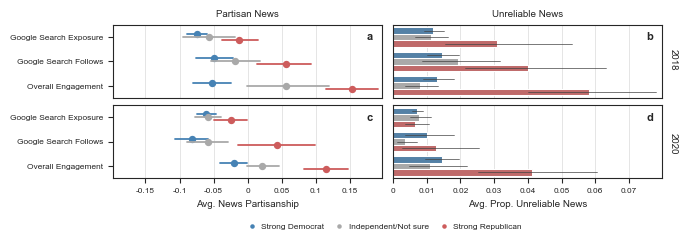

saved: figures/partisan_and_unreliable_news.png
saved: figures/partisan_and_unreliable_news.tiff
saved: figures/partisan_and_unreliable_news.pdf


In [15]:
# ==============================================================================
# Plot arguments

IMG_PATH = 'figures/partisan_and_unreliable_news.png'
OVERWRITE = True

# Group and labels
group = 'pid7_reduced'
palette = label_colors['pid7_reduced']
labels = ['Strong Democrat', 'Independent/Not sure', 'Strong Republican']

# Metric subsets and labels
colinfo_subset = colinfo.query("coltype == 'partisanship'")
metrics2018 = colinfo_subset.query("year == 2018 & result == 'main'")['col']
metrics2020 = colinfo_subset.query("year == 2020 & result == 'main'")['col']
metric_map = colinfo_subset.set_index("col")["datatype"].to_dict()

# Y-axis order
order = [
    'Google Search Exposure', 
    'Google Search Follows',
    'Overall Engagement', 
]

# ==============================================================================
# Plot settings

subplot_kws = {
    'nrows': 2, 
    'ncols': 2, 
    'figsize': (FIG_WIDTH['lg'], 2.25),    
    'sharey': True, 
    'gridspec_kw': {'hspace': 0.1, 'wspace':0.04},
}

pointplot_kws = {
    'scale': 0.6, 
    'errwidth': 1.3, 
    'dodge': 0.25,
    'linestyles': '',
    'palette': palette,
    'hue': group, 
    'hue_order': labels,
    'order':order,
}

bar_kws = {
    'linewidth': 0.75, 
    'errwidth': 0.5,
    'color': 'whitesmoke',
    'palette': palette,
    'order':order,
    'hue': group, 
    'hue_order': labels, 
}

grid_kws = {
    'color': '#D1D1D1', 
    'linestyle': '-', 
    'alpha': 0.8, 
    'linewidth': 0.5
}

# Make canvas
fig, ax = plt.subplots(**subplot_kws)
ax = ax.flatten('F')

# ------------------------------------------------------------------------------
# Partisan News

# ==============================================================================
# Plot 2018 Variables

data2018 = get_plot_data(users2018, metrics2018, group, labels, metric_map)
sns.pointplot(x='value', y='variable', ax=ax[0], data=data2018, **pointplot_kws)
ax[0].set(title='Partisan News', xlabel='', ylabel='')
ax[0].legend_.remove()
ax[0].tick_params(labelbottom=False)
remove_xaxis_ticks(ax[0])

# ==============================================================================
# Plot 2020 Variables

data2020 = get_plot_data(users2020, metrics2020, group, labels, metric_map)
sns.pointplot(x='value', y='variable', ax=ax[1], data=data2020, **pointplot_kws)
ax[1].set(title='', 
          xlabel='Avg. News Partisanship', 
          ylabel='',
          xlim=(-0.1975,.1975),
          xticks=[-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15],
          xticklabels=['-0.15', '-0.1', '-0.05', '0', 
                       '0.05', '0.1', '0.15'])

# ------------------------------------------------------------------------------
# Unreliable News

# ==============================================================================
# Plot arguments

# Metric subsets and labels
colinfo_subset = colinfo.query("coltype == 'unreliable'")
metrics2018 = colinfo_subset.query("year == 2018 & result == 'main'")['col']
metrics2020 = colinfo_subset.query("year == 2020 & result == 'main'")['col']
metric_map = colinfo_subset.set_index("col")["datatype"].to_dict()

# ==============================================================================
# Plot 2018 Variables

data2018 = get_plot_data(users2018, metrics2018, group, labels, metric_map)
sns.barplot(x='value', y='variable', ax=ax[2], data=data2018, **bar_kws)
ax[2].set(title='Unreliable News', xlabel='', xlim=(0,0.1), ylabel='')
ax[2].tick_params(labelbottom=False)
remove_xaxis_ticks(ax[2])
remove_yaxis_ticks(ax[2])

# ==============================================================================
# Plot 2020 Variables

data2020 = get_plot_data(users2020, metrics2020, group, labels, metric_map)
sns.barplot(x='value', y='variable', ax=ax[3], data=data2020, **bar_kws)
ax[3].set(title='', xlabel='Avg. Prop. Unreliable News', ylabel='', 
    xlim=(0,0.07989),
    xticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07],
    xticklabels=['0', '0.01', '0.02', '0.03', '0.04', '0.05', '0.06', '0.07'])
remove_yaxis_ticks(ax[3])


# ==============================================================================
# Format Legend

# Get legend handles and labels
handles, axlabels = ax[0].get_legend_handles_labels()
for _ax in ax[1:]:
    _ax.legend_.remove()

# Reorder and reformat legend
handles, axlabels = reorder_legend(handles, axlabels, order=labels)
fig.legend(handles, axlabels, 
    ncol=3,
    markerscale=0.5, 
    loc=(0.35, 0), 
    handletextpad=0.1,
    columnspacing=0.8,
    **legend_base_kws
)

# ==============================================================================
# Adjustments

# Selective X-axis sharing
ax[0].sharex(ax[1])
ax[2].sharex(ax[3])

# Add grids
for _ax in ax: _ax.grid(axis='x', which='major', **grid_kws)

# Spacing between xlabel and legend
fig.subplots_adjust(bottom=0.2)

# Set meta labels
x1 = 0.915
rotation = 270
fig.text(x1, 0.725, "2018", rotation=rotation, **title_kws)
fig.text(x1, 0.355, "2020", rotation=rotation, **title_kws)

# Subplot labels
text_x = [0.4875, 0.8825]
text_y = [0.83, 0.47]
text_xy = [reversed(tup) for tup in itertools.product(text_y, text_x)]
letters = string.ascii_lowercase[:len(text_xy)]
for l, (x, y) in zip(letters, text_xy):
    fig.text(x, y, l, **text_letters_kws)

# ==============================================================================
# Save as PNG and PDF

plt.show()
if OVERWRITE:
    fig.savefig(IMG_PATH, dpi=300, bbox_inches='tight')
    fig.savefig(IMG_PATH.replace('.png','.tiff'), dpi=300, bbox_inches='tight')
    fig.savefig(IMG_PATH.replace('.png','.pdf'), bbox_inches='tight')
    print(f"saved: {IMG_PATH}")
    print(f"saved: {IMG_PATH.replace('.png','.tiff')}")
    print(f"saved: {IMG_PATH.replace('.png','.pdf')}")

### PID-7 All Groups

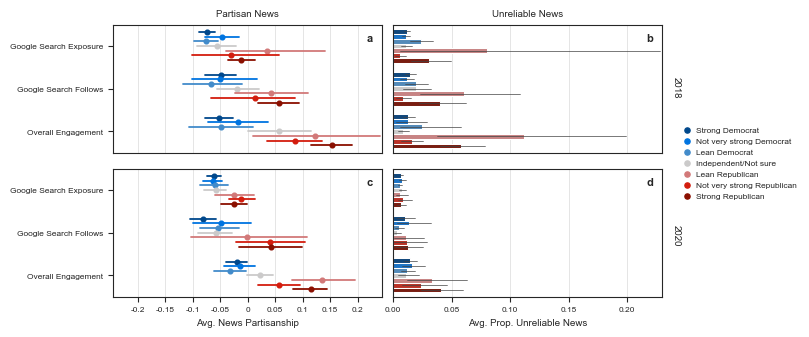

saved: figures/partisan_and_unreliable_news_all_groups.png
saved: figures/partisan_and_unreliable_news_all_groups.tiff
saved: figures/partisan_and_unreliable_news_all_groups.pdf


In [16]:
# ==============================================================================
# Plot arguments

IMG_PATH = 'figures/partisan_and_unreliable_news_all_groups.png'
OVERWRITE = True

# Group and labels
group = 'pid7_reduced'
palette = palette_alt
labels = label_orders[group]

# Metric subsets and labels
colinfo_subset = colinfo.query("coltype == 'partisanship'")
metrics2018 = colinfo_subset.query("year == 2018 & result == 'main'")['col']
metrics2020 = colinfo_subset.query("year == 2020 & result == 'main'")['col']
metric_map = colinfo_subset.set_index("col")["datatype"].to_dict()

# Y-axis order
order = [
    'Google Search Exposure', 
    'Google Search Follows',
    'Overall Engagement', 
]

# ==============================================================================
# Plot settings

subplot_kws = {
    'nrows': 2, 
    'ncols': 2, 
    'figsize': (FIG_WIDTH['lg'], 4),    
    'sharey': True, 
    'gridspec_kw': {'hspace': 0.125, 'wspace':0.04},
}

pointplot_kws = {
    'scale': 0.5, 
    'errwidth': 1.3, 
    'dodge': 0.65,
    'linestyles': '',
    'palette': palette,
    'hue': group, 
    'hue_order': labels,
    'order':order,
}

bar_kws = {
    'linewidth': 0.75, 
    'errwidth': 0.5,
    'color': 'whitesmoke',
    'palette': palette,
    'order':order,
    'hue': group, 
    'hue_order': labels, 
}

grid_kws = {
    'color': '#D1D1D1', 
    'linestyle': '-', 
    'alpha': 0.8, 
    'linewidth': 0.5
}

# Make canvas
fig, ax = plt.subplots(**subplot_kws)
ax = ax.flatten('F')

# ------------------------------------------------------------------------------
# Partisan News

# ==============================================================================
# Plot 2018 Variables

data2018 = get_plot_data(users2018, metrics2018, group, labels, metric_map)
sns.pointplot(x='value', y='variable', ax=ax[0], data=data2018, **pointplot_kws)
ax[0].set(title='Partisan News', xlabel='', ylabel='')
ax[0].legend_.remove()
ax[0].tick_params(labelbottom=False)
remove_xaxis_ticks(ax[0])

# ==============================================================================
# Plot 2020 Variables

data2020 = get_plot_data(users2020, metrics2020, group, labels, metric_map)
sns.pointplot(x='value', y='variable', ax=ax[1], data=data2020, **pointplot_kws)
ax[1].set(title='', 
          xlabel='Avg. News Partisanship', 
          ylabel='',
          xlim=(-0.245, 0.245),
          xticks=[-0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2],
          xticklabels=['-0.2', '-0.15', '-0.1', '-0.05', '0', 
                       '0.05', '0.1', '0.15','0.2'])

# ------------------------------------------------------------------------------
# Unreliable News

# ==============================================================================
# Plot arguments

# Metric subsets and labels
colinfo_subset = colinfo.query("coltype == 'unreliable'")
metrics2018 = colinfo_subset.query("year == 2018 & result == 'main'")['col']
metrics2020 = colinfo_subset.query("year == 2020 & result == 'main'")['col']
metric_map = colinfo_subset.set_index("col")["datatype"].to_dict()

# ==============================================================================
# Plot 2018 Variables

data2018 = get_plot_data(users2018, metrics2018, group, labels, metric_map)
sns.barplot(x='value', y='variable', ax=ax[2], data=data2018, **bar_kws)
ax[2].set(title='Unreliable News', xlabel='', xlim=(0,0.1), ylabel='')
ax[2].tick_params(labelbottom=False)
remove_xaxis_ticks(ax[2])
remove_yaxis_ticks(ax[2])

# ==============================================================================
# Plot 2020 Variables

data2020 = get_plot_data(users2020, metrics2020, group, labels, metric_map)
sns.barplot(x='value', y='variable', ax=ax[3], data=data2020, **bar_kws)
ax[3].set(title='', xlabel='Avg. Prop. Unreliable News', ylabel='', 
          xlim=(0,0.23),
)
remove_yaxis_ticks(ax[3])


# ==============================================================================
# Format Legend

# Set keyword arguments and include base kwargs
legend_kws = {
    'ncol': 1,
    'markerscale': 1.1,
    'loc': 'center right',
    'bbox_to_anchor': (0,0,1.10,1.07),
    'handletextpad': 0.1,
    'columnspacing': 0.8,
}
legend_kws.update(legend_base_kws)

# Get legend handles and labels
handles, axlabels = ax[0].get_legend_handles_labels()
for _ax in ax[1:]:
    _ax.legend_.remove()

# Reorder and reformat legend
handles, axlabels = reorder_legend(handles, axlabels, order=labels)

# Right-hand legend
fig.legend(handles, axlabels, **legend_kws)

# ==============================================================================
# Adjustments

# Selective X-axis sharing
ax[0].sharex(ax[1])
ax[2].sharex(ax[3])

# Add grids
for _ax in ax:
    _ax.grid(axis='x', which='major', **grid_kws)

# Spacing between xlabel and legend
fig.subplots_adjust(bottom=0.2)

# Set meta labels
fig.text(0.92, 0.725, "2018", rotation=270, **title_kws)
fig.text(0.92, 0.355, "2020", rotation=270, **title_kws)

# Subplot labels
text_x = [0.4875, 0.8825]
text_y = [0.847, 0.485]
text_xy = [reversed(tup) for tup in itertools.product(text_y, text_x)]
letters = string.ascii_lowercase[:len(text_xy)]
for l, (x, y) in zip(letters, text_xy):
    fig.text(x, y, l, **text_letters_kws)


# ==============================================================================
# Save as PNG and PDF

plt.show()
if OVERWRITE:
    fig.savefig(IMG_PATH, dpi=300, bbox_inches='tight')
    fig.savefig(IMG_PATH.replace('.png','.tiff'), dpi=300, bbox_inches='tight')
    fig.savefig(IMG_PATH.replace('.png','.pdf'), bbox_inches='tight')
    print(f"saved: {IMG_PATH}")
    print(f"saved: {IMG_PATH.replace('.png','.tiff')}")
    print(f"saved: {IMG_PATH.replace('.png','.pdf')}")

---
## Figure: Unreliable News CDF

In [17]:
# Create data structure for plotting
data_list = [
{
    'year': '2018', 
    'type': 'exposure',
    'dataset': 'Google Search',
    'datatype': 'Google Search Exposure',
    'result': 'main',
    'news': search2018['search_n_urls_news'],
    'unreliable': search2018['search_n_urls_fake_either'],
},
{
    'year': '2018', 
    'type': 'follows',
    'dataset': 'Google History',
    'datatype': 'Google Search Follows',
    'result': 'main',
    'news': follows2018['follow_n_news'],
    'unreliable': follows2018['follow_n_fake_either'],
},
{
    'year': '2018', 
    'type': 'engagement',
    'dataset': 'Browser History',
    'datatype': 'Overall Engagement',
    'result': 'main',
    'news': browse2018['browse_n_total_news'],
    'unreliable': browse2018['browse_n_total_fake_either'],
},
{
    'year': '2018', 
    'type': 'engagement',
    'dataset': 'Google History',
    'datatype': 'Overall Engagement',
    'result': 'si',
    'news': history2018['history_n_news'],
    'unreliable': history2018['history_n_fake_either'],
},
{
    'year': '2020', 
    'type': 'exposure',
    'dataset': 'Google Search',
    'datatype': 'Google Search Exposure',
    'result': 'main',
    'news': search2020['activity_gs_search_n_urls_news'],
    'unreliable': search2020['activity_gs_search_n_urls_fake_either'],
},
{
    'year': '2020', 
    'type': 'follows',
    'dataset': 'Tab Activity',
    'datatype': 'Google Search Follows',
    'result': 'main',
    'news': follows2020['activity_gs_follow_n_news'],
    'unreliable': follows2020['activity_gs_follow_n_fake_either'],
},
{
    'year': '2020', 
    'type': 'engagement',
    'dataset': 'Tab Activity',
    'datatype': 'Overall Engagement',
    'result': 'main',
    'news': activity2020['activity_n_news'],
    'unreliable': activity2020['activity_n_fake_either'],
},
{
    'year': '2020', 
    'type': 'engagement',
    'dataset': 'Browser History',
    'datatype': 'Overall Engagement',
    'result': 'si',
    'news': browse2020['browser_history_n_news'],
    'unreliable': browse2020['browser_history_n_fake_either'],
},
]

print("data_list:")
pd.DataFrame(data_list)

data_list:


,year,type,dataset,datatype,result,news,unreliable
0,2018,exposure,Google Search,Google Search Exposure,main,0 786.0 2 303.0 4 65.0 5 ...,0 9.0 2 6.0 4 34.0 5 7....
1,2018,follows,Google History,Google Search Follows,main,0 40.0 2 12.0 3 2.0 4 ...,0 1.0 2 1.0 3 0.0 4 0....
2,2018,engagement,Browser History,Overall Engagement,main,0 1067.085714 1 806.000000 2 2...,0 16.000000 1 3.000000 2 3.00...
3,2018,engagement,Google History,Overall Engagement,si,0 171.0 2 453.0 3 547.0 4 ...,0 4.0 2 1.0 3 41.0 4 ...
4,2020,exposure,Google Search,Google Search Exposure,main,0 1124.0 1 165.0 2 339.0 3 ...,0 2.0 1 0.0 2 10.0 3 12....
5,2020,follows,Tab Activity,Google Search Follows,main,0 26.0 1 0.0 2 2.0 3 16....,0 0.0 1 0.0 2 0.0 3 0.0 6 ...
6,2020,engagement,Tab Activity,Overall Engagement,main,0 5042.0 1 2502.0 2 527.0 3...,0 40.0 1 125.0 2 0.0 3 ...
7,2020,engagement,Browser History,Overall Engagement,si,0 10815.0 1 3742.0 2 349.0 3...,0 64.0 1 161.0 2 0.0 3 ...


2018 Google Search Exposure
86 participants (31.27%), account for 89.9% of exposure (3,534)
at least one for 69.1% of participants (190)

2018 Google Search Follows
74 participants (28.24%), account for 90.0% of follows (595)
at least one for 50.0% of participants (131)

2018 Overall Engagement
40 participants (12.01%), account for 89.9% of engagement (26,156)
at least one for 67.3% of participants (224)

2020 Google Search Exposure
115 participants (25.05%), account for 90.0% of exposure (4,664)
at least one for 59.0% of participants (271)

2020 Google Search Follows
41 participants (9.81%), account for 90.2% of follows (101)
at least one for 12.4% of participants (52)

2020 Overall Engagement
71 participants (11.89%), account for 89.9% of engagement (10,679)
at least one for 43.0% of participants (257)



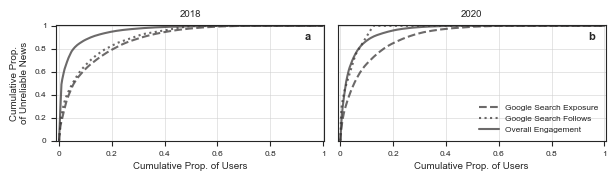

saved: figures/unreliable_news_cumsum.png
saved: figures/unreliable_news_cumsum.tiff
saved: figures/unreliable_news_cumsum.pdf


In [18]:
# ==============================================================================
# Plot arguments

IMG_PATH = 'figures/unreliable_news_cumsum.png'
OVERWRITE = True

# ==============================================================================
# Plot settings

linestyle_map = {
    'Google Search Exposure': '--', 
    'Google Search Follows': ':', 
    'Overall Engagement': '-',
}

subplot_kws = {
    'nrows': 1, 
    'ncols': 2, 
    'figsize': (FIG_WIDTH['lg'], 1.5),    
    'sharey': True, 
    'gridspec_kw': {'wspace': 0.05},
}

plt_kws = {
    'color': '#3b3838',
    'alpha': 0.75, 
}

grid_kws = {
    'axis': 'both',
    'which': 'major',
    'color': '#D1D1D1', 
    'linestyle': '-', 
    'alpha': 0.8, 
    'linewidth': 0.5
}


legend_kws = dict(
    handlelength=2.5, 
    loc='lower right',
    markerscale=0.9, 
    handletextpad=0.65,
    columnspacing=0.8,
)
legend_kws.update(legend_base_kws)

ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
ticklabels = ['0', '0.2', '0.4', '0.6', '0.8', '1']

ax_kws = { 
    'xlim': (-0.01, 1.005), 'xticks': ticks, 'xticklabels': ticklabels,
    'ylim': (0, 1.005), 'yticks': ticks, 'yticklabels': ticklabels,
}

# ==============================================================================
# Plot 

# Make canvas
fig, axs = plt.subplots(**subplot_kws)

for data in data_list:
    if data['result'] != 'main': continue
    
    year = data['year']
    name = data['datatype']
    col = data['unreliable']
    ax_idx = 0 if year == '2018' else 1
    
    # Get cumulative sum table
    cumsum_tab = cumulative_sum_table(col)
    cumsum_tab['rounded'] = cumsum_tab['p_cumsum'].round(3)
    s = cumsum_tab.query('rounded >= 0.899').iloc[0]    
    print(year, name)
    print(f"{s['n']:,.0f} participants ({s['n']/cumsum_tab['n'].max():.2%}), "
          f"account for {s['p_cumsum']:.1%} "
          f"of {data['type']} ({s['n_cumsum']:,.0f})")
    
    
    at_least_one = (col > 0).sum()
    at_least_one_p = at_least_one / col.shape[0]
    print(f"at least one for {at_least_one_p:.1%} of participants ({at_least_one:,})")
    print()
    
    # Reformat plot data
    x = [0] + cumsum_tab['p'].tolist()
    y = [0] + cumsum_tab['p_cumsum'].tolist()

    # Plot
    axs[ax_idx].plot(x, y, label=name, linestyle=linestyle_map[name], **plt_kws)
    axs[ax_idx].set(title=year, xlabel='Cumulative Prop. of Users', **ax_kws)
    axs[ax_idx].legend(**legend_kws)
    axs[ax_idx].grid(**grid_kws)
    # sns.despine(ax=axs[ax_idx])

# ==============================================================================
# Adjustments

axs[0].legend_.remove()
axs[0].set(ylabel='Cumulative Prop.\nof Unreliable News')
remove_yaxis_ticks(axs[1]) 
# axs[1].set(yticklabels=[])

# Subplot labels
text_x1 = 0.48
text_x2 = 0.88
text_y1 = 0.80
text_y2 = 0.44

fig.text(text_x1, text_y1, "a", **text_letters_kws)
fig.text(text_x2, text_y1, "b", **text_letters_kws)

# ==============================================================================
# Save as PNG and PDF

plt.show()

if OVERWRITE:
    fig.savefig(IMG_PATH, dpi=300, bbox_inches='tight')
    fig.savefig(IMG_PATH.replace('.png','.tiff'), dpi=300, bbox_inches='tight')
    fig.savefig(IMG_PATH.replace('.png','.pdf'), bbox_inches='tight')
    print(f"saved: {IMG_PATH}")
    print(f"saved: {IMG_PATH.replace('.png','.tiff')}")
    print(f"saved: {IMG_PATH.replace('.png','.pdf')}")

---

## Figures: Partisan by Unreliable News


### PID-7 Subset

coltype,year,datatype,dataframe,partisanship,unreliable
0,2018,Google Search Exposure,search2018,search_mean_weighted_bias_news,search_p_urls_news_fake_either
1,2018,Google Search Follows,follows2018,follow_mean_bias_news,follow_p_fake_news_either
2,2018,Overall Engagement,browse2018,browse_mean_bias_news,browse_p_total_fake_news_either
3,2020,Google Search Exposure,search2020,activity_gs_search_mean_weighted_bias_news,activity_gs_search_p_urls_fake_news_either
4,2020,Google Search Follows,follows2020,activity_gs_follow_mean_bias_news,activity_gs_follow_p_fake_news_either
5,2020,Overall Engagement,browse2020,browser_history_mean_bias_news,browser_history_p_fake_news_either


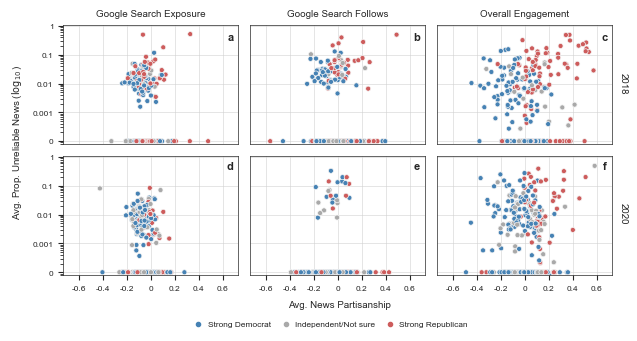

saved: figures/partisan_by_unreliable_news.png
saved: figures/partisan_by_unreliable_news.tiff
saved: figures/partisan_by_unreliable_news.pdf


In [19]:
# ==============================================================================
# Plot arguments

IMG_PATH = 'figures/partisan_by_unreliable_news.png'
OVERWRITE = True

# Group and labels
group = 'pid7_reduced'
order = label_orders[group]
palette = label_colors['pid7_reduced']
group_labels = ['Strong Democrat', 'Independent/Not sure', 'Strong Republican']
FILTER_GROUP = True

# Column titles
title_order = [
    'Google Search Exposure', 
    'Google Search Follows',
    'Overall Engagement', 
]

# Smallest nonzero min is BH == 0.0000750
nonzero_ymin = 0.0001


# ==============================================================================
# Plot settings

subplot_kws = {
    'nrows': 2, 
    'ncols': 3, 
    'sharex': True, 
    'sharey': True, 
    'figsize': (FIG_WIDTH['lg'], 3.25),    
    'gridspec_kw': {'hspace': 0.1, 'wspace':0.068}
}

scatter_kws = dict(
    s=13,
    alpha=1, 
    linewidth=0.5,
    edgecolor='whitesmoke', 
)

grid_kws = {
    'visible': True,
    'color': '#D1D1D1', 
    'linestyle': '-', 
    'alpha': 0.8, 
    'linewidth': 0.5
}

# ==============================================================================
# Plot Data

# Metric subsets and labels
tab = (colinfo.query("result == 'main' & col.str.contains('news')")
       .set_index(['year','datatype','dataframe','coltype'])['col']
       .unstack('coltype').reset_index())
display(tab)

# ==============================================================================
# Plot

# Make canvas
fig, ax = plt.subplots(**subplot_kws)
axs = ax.flatten()

for idx, row in tab.iterrows():
    x = row['partisanship']
    y = row['unreliable']
    data = dataframes[row['dataframe']].copy()
    if FILTER_GROUP:
        data = data[data[group].isin(group_labels)]
    data[y] = data[y].replace(0, nonzero_ymin)
    
    sns.scatterplot(x=x, y=y, hue=group, hue_order=order, palette=palette,
                    data=data, ax=axs[idx], **scatter_kws)
    axs[idx].legend_.remove()

# ==============================================================================
# Adjustments

axs[0].set(
    ylabel="",
    xlim=(-0.73, 0.73), 
    yscale='log', ylim=[0.00008, 1.1], 
    yticks=[0.0001, 0.001, 0.01, 0.1, 1],
    yticklabels=['0', '0.001', '0.01', '0.1', '1'],
    xticks=np.arange(-.6, .61, 0.2).tolist(), 
    xticklabels=['-0.6', '-0.4', '-0.2', '0', '0.2', '0.4', '0.6'],
)

for i in range(0, 3):
    remove_xaxis_ticks(axs[i])
    
for i in [1,2,4,5]:
    remove_yaxis_ticks(axs[i])


axs[3].set(ylabel="", xlabel="")
axs[4].set(xlabel="")
axs[5].set(xlabel="")

# Grids
for _ax in axs:
    _ax.grid(axis='both', which='major', **grid_kws)

# Set titles
for idx, title in enumerate(title_order):
    axs[idx].set_title(title, pad=8, **title_kws)

# Set meta labels
x1 = 0.915
rotation = 270
fig.text(x1, 0.7, "2018", rotation=rotation, **title_kws)
fig.text(x1, 0.3, "2020", rotation=rotation, **title_kws)

fig.text(0.06, 0.520, "Avg. Prop. Unreliable News ($\log_{10}$)", rotation=90, **title_kws)
fig.text(0.515, 0.02, "Avg. News Partisanship", rotation=0, **title_kws)

# Subplot labels
text_x = [0.361, 0.624, 0.889]
text_y = [0.842, 0.445]
text_xy = [reversed(tup) for tup in itertools.product(text_y, text_x)]
letters = string.ascii_lowercase[:len(text_xy)]
for l, (x, y) in zip(letters, text_xy):
    fig.text(x, y, l, **text_letters_kws)

# ==============================================================================
# Format Legend

# Get legend handles and labels
handles, axlabels = axs[0].get_legend_handles_labels()
handles, axlabels = reorder_legend(handles, axlabels, group_labels)
fig.legend(handles[:3], axlabels[:3], 
    ncol=3,
    markerscale=0.5, 
    loc='lower center', 
    bbox_to_anchor=(0.5,-0.075,0,0),
    handletextpad=0.1,
    columnspacing=0.8,
    **legend_base_kws
)


# change all spines
for _ax in axs:
    for axis in ['top','bottom','left','right']:
        _ax.spines[axis].set_linewidth(0.5)

# ==============================================================================
# Save as PNG and PDF

plt.show()

if OVERWRITE:
    fig.savefig(IMG_PATH, dpi=300, bbox_inches='tight')
    fig.savefig(IMG_PATH.replace('.png','.tiff'), dpi=300, bbox_inches='tight')
    fig.savefig(IMG_PATH.replace('.png','.pdf'), bbox_inches='tight')
    print(f"saved: {IMG_PATH}")
    print(f"saved: {IMG_PATH.replace('.png','.tiff')}")
    print(f"saved: {IMG_PATH.replace('.png','.pdf')}")

### PID-7 All Groups

coltype,year,datatype,dataframe,partisanship,unreliable
0,2018,Google Search Exposure,search2018,search_mean_weighted_bias_news,search_p_urls_news_fake_either
1,2018,Google Search Follows,follows2018,follow_mean_bias_news,follow_p_fake_news_either
2,2018,Overall Engagement,browse2018,browse_mean_bias_news,browse_p_total_fake_news_either
3,2020,Google Search Exposure,search2020,activity_gs_search_mean_weighted_bias_news,activity_gs_search_p_urls_fake_news_either
4,2020,Google Search Follows,follows2020,activity_gs_follow_mean_bias_news,activity_gs_follow_p_fake_news_either
5,2020,Overall Engagement,browse2020,browser_history_mean_bias_news,browser_history_p_fake_news_either


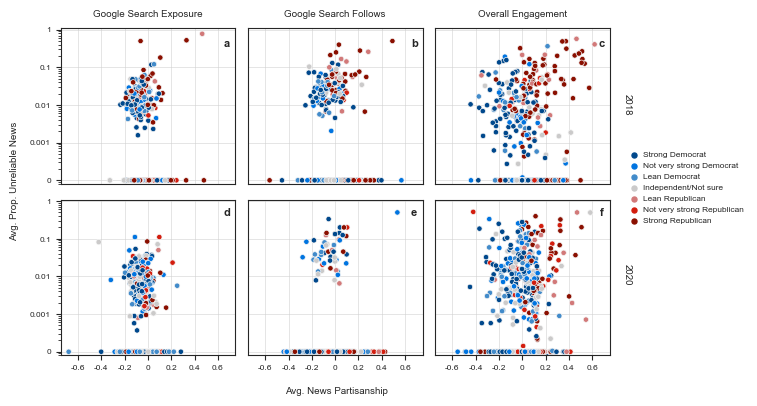

saved: figures/partisan_by_unreliable_news_all_groups.png
saved: figures/partisan_by_unreliable_news_all_groups.tiff
saved: figures/partisan_by_unreliable_news_all_groups.pdf


In [20]:
# ==============================================================================
# Plot arguments

IMG_PATH = 'figures/partisan_by_unreliable_news_all_groups.png'
OVERWRITE = True

# Group and labels
group = 'pid7_reduced'
palette = palette_alt
order = label_orders[group]
labels = ['Strong Democrat', 'Independent/Not sure', 'Strong Republican']

# Column titles
title_order = [
    'Google Search Exposure', 
    'Google Search Follows',
    'Overall Engagement', 
]

# Set Y-axis lim : smallest nonzero min is 2020 BH == 0.0000750
nonzero_ymin = 0.0001

# ==============================================================================
# Plot settings

subplot_kws = {
    'nrows': 2, 
    'ncols': 3, 
    'sharex': True, 
    'sharey': True, 
    'figsize': (FIG_WIDTH['lg'], 4.25),    
    'gridspec_kw': {'hspace': 0.1, 'wspace':0.07}
}

scatter_kws = dict(
    alpha=1, 
    edgecolor='whitesmoke', 
    linewidth=0.5,
    s=15,
)

grid_kws = {
    'visible': True,
    'color': '#D1D1D1', 
    'linestyle': '-', 
    'alpha': 0.8, 
    'linewidth': 0.5
}

# ==============================================================================
# Plot Data

# Metric subsets and labels
tab = (colinfo.query("result == 'main' & col.str.contains('news')")
       .set_index(['year','datatype','dataframe','coltype'])['col']
       .unstack('coltype').reset_index())
display(tab)

# ==============================================================================
# Plot

# Make canvas
fig, ax = plt.subplots(**subplot_kws)
axs = ax.flatten()

for idx, row in tab.iterrows():
    x = row['partisanship']
    y = row['unreliable']
    data = dataframes[row['dataframe']].copy()
    data[y] = data[y].replace(0, nonzero_ymin)    
    sns.scatterplot(x=x, y=y, hue=group, hue_order=order, palette=palette,
                    data=data, ax=axs[idx], **scatter_kws)
    axs[idx].legend_.remove()

# ==============================================================================
# Adjustments

axs[0].set(
    ylabel="",
    xlim=(-0.75, 0.75), 
    yscale='log', ylim=[0.00008, 1.1], 
    yticks=[0.0001, 0.001, 0.01, 0.1, 1],
    yticklabels=['0', '0.001', '0.01', '0.1', '1'],
    xticks=np.arange(-.6, .61, 0.2).tolist(), 
    xticklabels=['-0.6', '-0.4', '-0.2', '0', '0.2', '0.4', '0.6'],
)

for i in range(0, 3):
    remove_xaxis_ticks(axs[i])
    
for i in [1,2,4,5]:
    remove_yaxis_ticks(axs[i])


axs[3].set(ylabel="", xlabel="")
axs[4].set(xlabel="")
axs[5].set(xlabel="")

# Grids
for _ax in axs:
    _ax.grid(axis='both', which='major', **grid_kws)

# Set titles
for idx, title in enumerate(title_order):
    axs[idx].set_title(title, pad=10, **title_kws)

# Set meta labels
x1 = 0.925
rotation = 270
fig.text(x=x1, y=0.7, s="2018", rotation=rotation, **title_kws)
fig.text(x=x1, y=0.3, s="2020", rotation=rotation, **title_kws)

fig.text(0.06, 0.520, "Avg. Prop. Unreliable News", rotation=90, **title_kws)
fig.text(0.515, 0.025, "Avg. News Partisanship", rotation=0, **title_kws)

# Subplot labels
text_x = [0.360, 0.624, 0.889]
text_y = [0.843, 0.446]
text_xy = [reversed(tup) for tup in itertools.product(text_y, text_x)]
letters = string.ascii_lowercase[:len(text_xy)]
for l, (x, y) in zip(letters, text_xy):
    fig.text(x, y, l, **text_letters_kws)

# ==============================================================================
# Format Legend

# Reorder and reformat legend
handles, axlabels = axs[0].get_legend_handles_labels()
handles, axlabels = reorder_legend(handles, axlabels, order=order)
fig.legend(handles, axlabels, 
    ncol=1,
    markerscale=0.6, 
    loc='center right', 
    bbox_to_anchor=(0,0,1.10,1.01),
    handletextpad=0.1,
    columnspacing=0.8,
    **legend_base_kws
)

# ==============================================================================
# Save as PNG and PDF

plt.show()

if OVERWRITE:
    fig.savefig(IMG_PATH, dpi=300, bbox_inches='tight')
    fig.savefig(IMG_PATH.replace('.png','.tiff'), dpi=300, bbox_inches='tight')
    fig.savefig(IMG_PATH.replace('.png','.pdf'), bbox_inches='tight')
    print(f"saved: {IMG_PATH}")
    print(f"saved: {IMG_PATH.replace('.png','.tiff')}")
    print(f"saved: {IMG_PATH.replace('.png','.pdf')}")

## Table: Spearman Correlations

In [21]:
FP_TABLE = 'tables/spearman_tests.tex'

# Metric subsets and labels
tab = (colinfo.query("col.str.contains('news')")
       .set_index(['year','datatype','dataframe','dataset','coltype'])['col']
       .unstack('coltype').reset_index())
labels = ['Strong Democrat', 'Independent/Not sure', 'Strong Republican']

# Build table
stat_list = []
for idx, row in tab.iterrows():
    
    data = dataframes[row['dataframe']]
    
    out = {}
    out['year'] = row['year']
    out['type'] = row['datatype']
    out['name'] = row['dataset']
    out['group'] = 'Overall'
    
    subset = data
    stat = spearmanr(subset, row['partisanship'], row['unreliable'])
    out.update(stat)
    out['n'] = data[[row['partisanship'], row['unreliable']]].dropna().shape[0]
    stat_list.append(out)
    
    for label in label_orders['pid7_reduced']:
        subset = data.query("pid7_reduced == @label")
        
        out = {}
        out['n'] = subset[[row['partisanship'], row['unreliable']]].dropna().shape[0]
        
        out['year'] = row['year']
        out['type'] = row['datatype']
        out['name'] = row['dataset']
        out['group'] = label
        
        stat = spearmanr(subset, row['partisanship'], row['unreliable'])
        out.update(stat)
        stat_list.append(out)

tab = pd.DataFrame(stat_list)

# ==============================================================================
# P-value correction

from statsmodels.stats.multitest import multipletests
def adjust_pvals(gdf, method='holm'):
    decisions, adj_pvals, sidak_aplha, bonf_alpha = multipletests(
        pvals=gdf['p'], 
        alpha=0.05,
        method=method
    )
    return adj_pvals

pvals = (tab.query("group != 'Overall'")
         .groupby(["year", "type", "name"])
         .apply(adjust_pvals)
         .apply(pd.Series)) 
pvals.columns = label_orders['pid7_reduced']
pvals = pvals.reset_index().melt(id_vars=["year", "type", "name"], 
                                 var_name='group', value_name="padj")
tab = tab.merge(pvals, how='left', on=['year','type','name','group'])

print("significant P values")
display(tab[((tab['p'] < 0.05) | (tab['padj'] < 0.05))])

# Format columns
tab['p'] = tab['padj']
tab['p_sig'] = tab['p'].astype(float).apply(p_value_sig)
val_cols = ['rho', 'p']
tab[val_cols] = tab[val_cols].apply(stringify, fmt=".3f")
tab['p'] = tab['p'] + tab['p_sig']
tab.drop(columns=['p_sig','padj'], inplace=True)

# Filter for primary groups
tab = tab.query(f"group in @labels")

    
# ==============================================================================
# Set MultiIndex

# Columns ----------------------------------------------------------------------

tab.set_index(["year", "type", "name", "group"], inplace=True)
tab = tab.unstack('group')
tab.columns = tab.columns.swaplevel(0, 1)
cols_0 = pd.Categorical(tab.columns.get_level_values(0), ordered=True,
                   categories=['Overall'] + labels)
cols_1 = pd.Categorical(tab.columns.get_level_values(1), ordered=True,
                    categories=['n', 'rho', 'p'])
tab.columns = pd.MultiIndex.from_arrays([cols_0, cols_1]) 
tab = tab.sort_index(axis=1, level=[0, 1])

# Index ------------------------------------------------------------------------

cols_0 = pd.Categorical(tab.index.get_level_values('year'), ordered=True,
                        categories=[2018, 2020])
cols_1 = pd.Categorical(tab.index.get_level_values('type'), ordered=True,
                        categories=['Google Search Exposure', 
                                    'Google Search Follows',
                                    'Overall Engagement'])
cols_2 = pd.Categorical(tab.index.get_level_values('name'), ordered=True,
                        categories=['Google SERPs','Browser History',
                                    'Google History', 'Tab Activity'])
tab.index = pd.MultiIndex.from_arrays([cols_0, cols_1, cols_2]) 
tab = tab.sort_index(axis=0, level=[0, 1, 2])
tab.index.names = ['year', 'type', 'name']

# ==============================================================================
# Save

# Save LaTeX table
tab.style.to_latex(column_format='rrrrrrl', buf=FP_TABLE)
print(f"saved: {FP_TABLE}")
display(tab)

significant P values


,year,type,name,group,rho,p,n,padj
3,2018,Google Search Exposure,Google SERPs,Lean Democrat,0.442137,0.034650,23,0.242547
9,2018,Google Search Follows,Google History,Strong Democrat,-0.273497,0.009100,90,0.063698
17,2018,Overall Engagement,Browser History,Strong Democrat,-0.380356,0.000028,115,0.000193
23,2018,Overall Engagement,Browser History,Strong Republican,0.335866,0.001292,89,0.007751
31,2018,Overall Engagement,Google History,Strong Republican,0.377095,0.001291,70,0.009040
32,2020,Google Search Exposure,Google SERPs,Overall,-0.162320,0.000524,453,NaN
41,2020,Google Search Follows,Tab Activity,Strong Democrat,0.204546,0.044459,97,0.311214
55,2020,Overall Engagement,Tab Activity,Strong Republican,0.407467,0.000918,63,0.006426
57,2020,Overall Engagement,Browser History,Strong Democrat,-0.237250,0.000951,191,0.006657


saved: tables/spearman_tests.tex


Strong Democrat                   Independent/Not sure                 \
                                                          n     rho         p                    n     rho      p   
year type                   name                                                                                    
2018 Google Search Exposure Google SERPs                 98  -0.133     0.956                   28   0.058  1.000   
     Google Search Follows  Google History               90  -0.273     0.064                   25   0.218  1.000   
     Overall Engagement     Browser History             115  -0.380  0.000***                   30  -0.093  1.000   
                            Google History               98  -0.192     0.346                   27  -0.059  0.890   
2020 Google Search Exposure Google SERPs                130  -0.149     0.627                   74  -0.140  1.000   
     Google Search Follows  Tab Activity                 97   0.205     0.311                   54  -0.080  1.000   
     Overall Engagement     Browser History             191  -0.237   0.007**                  104   0.027  1.000   
                            Tab Activity                154  -0.140     0.495                   88  -0.013  1.000   

                                            Strong Republican                   
                                                            n     rho        p  
year type                   name                                                
2018 Google Search Exposure Google SERPs                   74  -0.030    1.000  
     Google Search Follows  Google History                 63   0.029    1.000  
     Overall Engagement     Browser History                89   0.336  0.008**  
                            Google History                 70   0.377  0.009**  
2020 Google Search Exposure Google SERPs                   50  -0.109    1.000  
     Google Search Follows  Tab Activity                   36  -0.103    1.000  
     Overall Engagement     Browser History                73   0.223    0.345  
                            Tab Activity                   63   0.407  0.006**